This notebook documents the filtering steps that were applied to the public mouse RRBS/WGBS datasets. Most of these scripts here are an example of scripts. This was mostly processed on a parallel computing infrastructure or using shell scripts. These steps were identical as described in DataProcessing_EvolutionaryTrends. So these next few sections will echo this. 

# Mouse WGBS/RRBS Public

## Outline describing operations conducted in a parralel computing environment

### GEO and SRA data sequencing alignment

GEO studies used in this section include GSE60012 (Reizel et al., 2015), GSE52266 (Cannon et al., 2014), SRA344045 (Gravina et al., 2016)

GEO data and SRA data were downloaded and aligned to a bisulfite-converted Ensembl mm10 genome with the script, 'script/methPipe.py' This script will not work out of the box and has to be configured according to the comments in the script itself.

In this case, these studies did not correspond to multiple runs, so the SRR files were directly converted to SRSids

### Scripts for determining which sites were covered across all

In order to find sites that were commonly profiled across our RRBS studies, we used the script 'scripts/counts_sites_per_sample_zeros_list.py'. This script takes as input the SRS*.bismark.cov file (zero-based), a file describing the length of chromosomes (tab-delimited), The directory to write out results and the sample identifier. This script will create a dictionary indexed by the chromosome, with a vector of zeros of length chromosome. It then reads the bismark.cov file, and adds a 1 to the appropriate index. The script will then create a file for each chromosome consisting of the sites that are profiled per chromosome.

Next, after all files have been processed, a second script then adds the resulting array to find sites that are commonly profiled across samples. This was also done in a parallel computing environment, using the script 'script/collapse_coverage_per_chrm_basebed_input.py'. This script takes as input, the directory where the output of the previous script resides, the chromosome, the percent of total samples required to be covered, a directory to write the output, and a genome file (identical to that used in the first section), and a single column file describing which specific samples to include in the counting. It is in this step that I have reduced the chromosome space to search to those aligning to 1-19. The script will then create a zeros vector as long as the chromosome, and find the files corresponding to the sample-chromosome generated by the previous script, and adds it to the total count. This vector describing the positions and the counts are then filtered by the percent filter, and a file is written with acceptable sites for that chromosome in the format of 'chr:start:stop', in zero-based form. It also saves the count vector itself in numpy format. When using this script, I chose ~30% to reduce the space, yet leave enough room for other filters to apply later. 

Next, after sites for each chromosome have been identified, we then concatenated the file with the sites and sorted it, creating a file that is a single column file describing the chr:start:stop to consider (site2index_file). This is used as input to the next script, 'script/create_sample_by_site_matrix_srsidsysargv.py'. Inputs include the site2index_file, the bismark.cov file, the file to write out (in hdf format), and the srs id. This site2index_file is then used to create a dictionary that is keyed by the site and associated with the number in the sorted site2index file. It also creates two vectors that is equal to the length of the sites kept, one for the methylation value and one for the number of reads supporting that site. The script then reads the bismark.cov file to keep the sites indicated by the site2index_file. The script also checks if the methylation value is represented by a fraction or by a percent, if by a percent, the value is converted to a fraction. These values are then recorded into the vectors using the index corresponding to the site. Both vectors are then converted to a pandas dataframe, where the columns correspond to the sitenames, and the index is recorded by the srs_id. This file is then saved as an hdf file where the sheets correspond to the values and reads.

Finally, the resulting pandas dataframes are concatenated for the samples considered into a single dataframe. This is accomplished using 'scripts/make_df_1x1x.py.' This script takes as input the directory where the hdf files where the saved. This is then used to concatenate the different dataframes (warning may require large ram due to the number of sites kept), and then creates a unified dataframe with all samples and the methylation values, and a dataframe describing the reads supporting that site in the same directory. The single sample dataframes are then deleted, and this is used as input for further filtering steps described below.

#### Specifically for WGBS long-lived mice and untreated, wild type data.

We collaborated with Dr. Peter D. Adams lab who provided us with his bismark.cov files. Since preprocessing was done in his lab, we simply obtained bismark.cov files. These files were aligned to an mm9 version, instead of reprocessing, we chose to use UCSC liftOver to mm10, and since our analyses were already limited to sites mapping to chromosome 1-19, we feel this was adequate. Most reads aligned.

## Filtering for final sites.

We first identified CpG sites in studies that profiled multiple ages. Therefore, we used Reizel et al., Gravina et al., and our own control mice to identify sites.

### Notebook imports

In [1]:
from __future__ import division
import os
import subprocess
import csv
import imp
import re
import numpy as np
import random 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import itertools
%matplotlib inline
import collections
twto = imp.load_source('twto','scripts/twang_toolbox.py')
meth = imp.load_source('meth','scripts/methy_parsing.py')
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as hac
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.lda import LDA
from sklearn import datasets
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.sandbox.stats as smstats
from sklearn import cross_validation, linear_model, metrics

/cellar/users/twang/anaconda/lib/python2.7/site-packages/sklearn/lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)


In [2]:
sns.set(context='notebook',style='ticks')

In [3]:
hdffile = 'data/epigenetic_aging_model/preprocessing/Full_Liver_df_firstpasssites.h5'
methy_raw = pd.read_hdf(hdffile,'raw_methy_vals')
methy_reads = pd.read_hdf(hdffile,'reads')

In [4]:
methy_reads_filter = methy_reads >=2

In [5]:
methy_raw_read_filtered = methy_raw[methy_reads_filter]

In [6]:
filter_sites = methy_raw_read_filtered.isnull().sum()/methy_raw_read_filtered.shape[0]

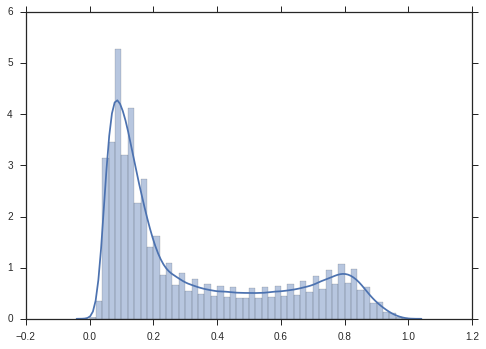

In [7]:
sns.distplot(filter_sites)

In [8]:
#For this subset we wanted to impute as little as we could
#hence the low read count requirement and the low sites missing requirements
filter_sites_keep = filter_sites[filter_sites<0.03].index

In [9]:
methy_raw_filtered = methy_raw_read_filtered[filter_sites_keep]

In [10]:
nullspersamp = methy_raw_filtered.isnull().sum(axis=1)/methy_raw_filtered.shape[1]

In [11]:
filter_samps = nullspersamp[nullspersamp<0.3].index

In [12]:
len(filter_samps)

119

In [13]:
methy_raw_filtered_filtersamps = methy_raw_filtered.loc[filter_samps]
std_sites = methy_raw_filtered_filtersamps.std()

In [14]:
#Since we were imputing by the mean, wanted to keep very high variant sites out
lowstd = std_sites[(std_sites<=0.2) & (std_sites>0)].index

In [15]:
methy_raw_filtered_filtersamps_lowstd = methy_raw_filtered_filtersamps[lowstd]
methy_raw_filtered_filtersamps_lowstd_imputed = methy_raw_filtered_filtersamps_lowstd.fillna(methy_raw_filtered_filtersamps_lowstd.mean())

In [16]:
methy_raw_filtered_filtersamps_lowstd_imputed.shape

(119, 7637)

In [17]:
sites = sorted([x.split(':')+[x] for x in lowstd],key=lambda x: (x[0],int(x[1])))
outbed = 'data/epigenetic_aging_model/preprocessing/2xSelectedSites.bed'
twto.write_file(sites,outbed)

Using these sites, we then used intersectBed using outbed as the -a file. The specific unix command that was used was 'intersectBed -wa -wb -sorted -filenames -a $outbed -b *.bismark.*  >  ${study}_intersectedAll_file.txt'

These are example scripts resulting from the intersected file for sites that overlapped.

For public RRBS data profiling a single time point

In [18]:
#datad = bed_bath_with SRS_bismark.cov_files
#samples = [x[0].split('.')[0] for x in twto.make_files_tuple_by_ext(datad,'.bed')]
#sampleid_dict = {x.split('SRS')[1]:i for i,x in enumerate(samples)}
#sites = methy_raw_filtered_filtersamps_lowstd_imputed.columns
#feature2numberdict ={x:i+1 for i,x in enumerate(sites)}
#feature2numberdict_rev = {i:x for x,i in feature2numberdict.iteritems()}

In [19]:
#intersected_all_file = single_time_point_SRS_bismark.cov_intersectedAll.txt
#n_sample=len(sampleid_dict)
#cov_mat = np.zeros((n_sample,len(feature2numberdict)+1))
#cov_mat[:]=np.nan
#cov_mat,reads_mat = meth.read_values_into_array_reads_samplecode_filtersites_intersectedAll(sampleid_dict,feature2numberdict,cov_mat,intersected_all_file,empty_array_reads=True,splitsrr=True,divide100=False,SRR='SRS')
#index = pd.Series(cov_mat[:,0]).map({i:'SRS{}'.format(x) for x,i in sampleid_dict.iteritems()})
#columns = pd.Series(range(1,len(feature2numberdict)+1)).map(feature2numberdict_rev)
#df = pd.DataFrame(cov_mat[:,1:],index=index,columns=columns)
#df_reads = pd.DataFrame(reads_mat[:,1:],index=index,columns=columns)

In [20]:
#Because PRJNA280119 had over 90% of the data missing, we removed it.
#df_dropPRJNA280119 = df.loc[tt.loc[tt.Study!='PRJNA280119'].index]

In [21]:
#cannon_df = df_dropPRJNA280119.fillna(methy_raw_filtered_filtersamps_lowstd.mean())

For long-lived mice

In [22]:
#metadata = 'data/meta_data/AdamsMetaData.txt'
#adams_meta_data = pd.read_csv(metadata,sep='\t')
#adams_meta_data['mouse'] = map(lambda z: ['Ames','Miller'][z],[x.startswith('Miller') for x in adams_meta_data['FileName'].values])
#adams_meta_data.index = adams_meta_data['FileName'].values
#feature2numberdict ={x:i+1 for i,x in enumerate(liver_df_vals_1x1x_filter_filtersamps_impute.columns)}
#feature2numberdict_rev = {i:x for x,i in feature2numberdict.iteritems()}
#intervention_path = directory_with_bismark_files_for_long_lived_mice
#concatdf = []
#concat_reads = []
#mouse_map = {'AmesDwarf':'Ames','Miller_Young_Old_CR_Rapa':'Miller'}
#groupings = {'AmesDwarf':['DY','DO'],'Miller_Young_Old_CR_Rapa':['Rapa','CR']}

#for mouse_dir in ['AmesDwarf','Miller_Young_Old_CR_Rapa']:
#    filein=os.path.join(outd,'{}_intersectedAll.txt'.format(mouse_dir))
#    sampleid_dict = {x:i for i,x in enumerate(adams_meta_data.loc[adams_meta_data.Cohort.isin(['WTY','WTO','Young','Old'])].index)}
#    n_sample=len(sampleid_dict)
#    cov_mat = np.zeros((n_sample,len(feature2numberdict)+1))
#    cov_mat[:]=np.nan
#    cov_mat,reads_mat = meth.read_values_into_array_reads_samplecode_filtersites_intersectedAll(sampleid_dict,feature2numberdict,cov_mat,filein,empty_array_reads=True,splitsrr=False,divide100=True,SRR='_mapped_sorted.bed')
#    index = pd.Series(cov_mat[:,0]).map({i:'{}'.format(x) for x,i in sampleid_dict.iteritems()})
#    columns = pd.Series(range(1,len(feature2numberdict)+1)).map(feature2numberdict_rev)
#    df = pd.DataFrame(cov_mat[:,1:],index=index,columns=columns)
#    df_reads_iter = pd.DataFrame(reads_mat[:,1:],index=index,columns=columns)
#    concatdf.append(df)
#    concat_reads.append(df_reads_iter)
#df_adams_raw = pd.concat(concatdf)
#df_adams_meanpermouse = df_adams_raw.T.fillna(df_adams_raw.mean(axis=1)).T
#df_adams_reads = pd.concat(concat_reads)

The results of this can be viewed in 'data/epigenetic_aging_model/preprocessing/Cannon_1xSites_selected.h5' and 'data/epigenetic_aging_model/preprocessing/Interventions_1xSites_selected.h5'. These hdf files are indexed by 'raw_methy_mat' for non-imputed dataframe, 'methy_mat' for imputed dataframe and 'reads' for reads supported by selected sites.

The 3 dataframes were concatenated together using pandas, the ages in days were transformed using np.log2(age_days) and saved to 'data/AllData_non_normalized_data_logage.h5'

To assess average depth of coverage for sites considered, we concatenated the reads dataframes generated above for the 7,628 remaining sites. Then we summed the values for each row, corresponding to reads in a sample, and divded by the number of sites. These data are presented in Supplementary Table 1 (detailed tabs).

### Combat Normalization

We next used comBat on all the data together. This was done using comBat with the SVA R-package using rpy2.ipython module. The script can be viewed at 'scripts/combat_nonparametric.ipy'. This script takes as input the concatenated dataframe in hdf format, that is keyed by 'methy_mats' for the imputed methylation values and 'covariates' for the covariates. It also takes as input the name of the normalized file. The results of running this script are saved under 'data/AllData_combatnonpara_logage.h5'. After running combat, some sites were set to NaN, which we removed from further analysis, resulting in 7,628 CpG sites.

In [23]:
normalized_all_data_f = 'data/AllData_combatnonpara_logage.h5'
normed_methy_mat = pd.read_hdf(normalized_all_data_f,'methy_mat')
covariates = pd.read_hdf(normalized_all_data_f,'covariates')

In [24]:
normed_methy_mat.shape

(173, 7628)

We then designated some of the wild type mice for training and some for test. The files containing the training and test indexes can be found in 'data/epigenetic_aging_model/preprocessing/Train_inds.txt' and 'Test_inds.txt' in the same directory.

In [25]:
train_inds_f = 'data/epigenetic_aging_model/preprocessing/Train_inds.txt'
train_inds = twto.read_single_col_file(train_inds_f)
test_inds_f = 'data/epigenetic_aging_model/preprocessing/Test_inds.txt'
test_inds = twto.read_single_col_file(test_inds_f)

In [26]:
#inds_dict = {'TrainingData':train_inds,'TestData':test_inds}
#data_d = 'data/epigenetic_aging_model/'
#for key in inds_dict:
#    inds = inds_dict[key]
#    outhdf = os.path.join(data_d,'CombatNormalized{}.h5'.format(key))
#    df = normed_methy_mat.loc[inds]
#    covs = covariates.loc[inds]
#    twto.save_hdf_file({'methy_mat':df,'covariates':covs},outhdf)

These files were used as input for the epigenetic trianing model described in MouseEpigeneticAgingModel.ipynb

# Assessing average reads per CpG site.

Since we used RRBS and WGBS studies, we thought the easiest way to give some idea of the depth of coverage of the experiment would be most fair at the level of unique CpGs. This next section details how this was done. It is similar to the counting sites, instead of keeping track of sites, we keep track of reads for all genomic loci. To count the number of unique sites that were profiled by a sample, we used coverageBed of bedtools, providing as input, the bismark.cov file and the genome file.

To keep track of the number of reads for all CpG sites, we used the script 'scripts/counts_sites_per_sample_zeroslist_reads.py'. It takes the same inputs as counts_sites_per_sample_zeros_list.py.

To assess what fraction of each chromosome was covered, we used coverageBed. This was wrapped into a python script 'script/run_coverage_bed_perdirectory.py'. This script takes as input a bed file corresponding to the genome file, the directory with the SRS*.bismark.cov files, the directory to write out results, where individual SRS.bismark.cov file is saved, and also takes a string that is part of the filename to find the files within the SRS.bismark.cov directory to process. For example, the wildcard matcher could be '.bismark.cov'

These results were then concatenated to the alignment report generated by bismark, which is presented in Supplementary Table 1 (detailed tabs). The results of this particular procedure are saved 'data/epigenetic_aging_model/preprocessing/AdditionalFile1_PublicData.txt (for public data) and 'data/epigenetic_aging_model/preprocessing/WGBS_Here_mm9_mm10.txt'. For the alignment details of long-lived and their control mice, we obtained the table from Peter Adams groups (Neil Robertson). The mm9 and mm10 detail the average depth per coverage and average fraction covered. These tables show that the liftOver procedure did not introduce biases, as the numbers are roughly equivelent overall.